## A backward dynamic programming algorithm.

Scenario:

An NGO sells a single handcrafted backpack produced by under-represented artisan groups. Each month, over a 120-month horizon, they reach one of four audience-size tiers—40, 60, 80, or 100 customers—and choose a campaign label (marketing message) highlighting a different artisan community. Each label yields a unit profit per customer as follows:

|       Label      | Artisan Group Highlighted        | Profit/Customer (£) |
| :--------------: | :------------------------------- | :-----------------: |
|   **EcoNomad**   | Women-led cooperatives           |         15         |
|  **TrailBlazer** | Disability-led artisan studios   |         9         |
| **ClassicCarry** | Minority-owned craft collectives |         12         |

Their goal is to maximize total expected profit over the 120 months by selecting the best label each month.

In [12]:
R = [15, 9, 12]

In [9]:
import numpy as np

def create__trans_prob(num_states, num_actions):
    """
    Create a transition probability matrix for a reinforcement learning problem.
    
    Parameters:
    - num_states: Number of states in the environment.
    - num_actions: Number of actions available in the environment.
    
    Returns:
    - P: Transition probability matrix of shape (num_states, num_actions, num_states) using Dirichlet.
    """
    alpha = np.ones(num_states)  # Dirichlet distribution parameter
    P = np.zeros((num_states, num_actions, num_states))
    for s in range(num_states):
        for a in range(num_actions):
            P[s, a, :] = np.random.dirichlet(alpha)  # transition probabilities for each state-action pair
    return P

In [60]:
# initialize value function values

import numpy as np

def create__trans_prob(num_states, num_actions):
    """
    Create a transition probability matrix for a reinforcement learning problem.
    
    Parameters:
    - num_states: Number of states in the environment.
    - num_actions: Number of actions available in the environment.
    
    Returns:
    - P: Transition probability matrix of shape (num_states, num_actions, num_states) using Dirichlet.
    """
    alpha = np.ones(num_states)  # Dirichlet distribution parameter
    P = np.zeros((num_states, num_actions, num_states))
    for s in range(num_states):
        for a in range(num_actions):
            P[s, a, :] = np.random.dirichlet(alpha)  # transition probabilities for each state-action pair
    return P


def backward_dynamic_programming(T, states, actions, R, P):
    """
    Perform backward dynamic programming to compute the value function and action values.
    Parameters:
    - T: Number of time steps.
    - states: List of states in the environment.
    - actions: Actions available in the environment.
    - P: Transition probability matrix of shape (num_states, num_actions, num_states).
    
    Returns:
    - V: Value function for each state at each time step.
    - A: Best action for each state at each time step.
    """

    num_states = len(states)  # number of states
    num_actions = len(actions)  # number of actions

    V = np.zeros((T+1, num_states)) # initial value function for 80 time steps and 4 states
    A = np.zeros((T, num_states)) # action values for 80 time steps and 4 states

    for t in reversed(range(T)):
        for i in range(num_states): # loop over states
            # initialize best value and action
            best_val = -np.inf  
            best_action = None 
            # loop over actions to find the best action for the current state
            for a in range(num_actions): # loop over actions
                q_ia = 0 # initialize action value
                # calculate the action value q(s, a) using the Bellman equation
                for j in range(num_states): # loop over next states
                    # r = np.random.normal(50, 40) # sample a reward from a normal distribution
                    r = R[a]*states[i]  # reward based on the action and state
                    q_ia = + r + 0.1*P[i][a][j]*V[t+1, j]  # reward + discounted value of next state
                if q_ia > best_val: # if the action value is better than the best value found so far
                    best_val = q_ia # update best value
                    best_action = a # update best action
            V[t][i] = best_val # store the best value for the current state at time t
            A[t][i] = best_action # store the best action for the current state at time t
    return V, A            

In [61]:

T = 120
states = list(range(40, 61))  # example states
actions = [0, 1, 2]  # example actions
num_states = len(states)  # number of states
num_actions = len(actions)  # number of actions
R = [15, 9, 12]  # rewards for each action
P = create__trans_prob(num_states, num_actions) # create transition probability matrix
Vs, As = backward_dynamic_programming(T, states, actions, R, P)  # perform backward dynamic programming

In [63]:
Vs.shape

(121, 21)

<Axes: >

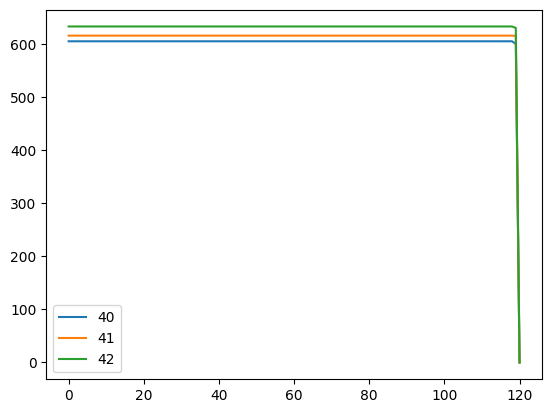

In [49]:
import pandas as pd
pd.DataFrame(Vs, columns=states, index=range(T+1)).iloc[:, 0:3].plot()

Consider a network of two products: product 1 (bags) has 10 units in inventory, while product 2 (raincoats) has 20 units in inventory. Customers may buy product 1, product 2, or both products. The price is £15 for product 1, £20 for product 2, and £30 if a customer wants to buy both products 1 and 2. The products can be sold over a time horizon of T = 90 periods. The arrival probabilities in each time period are constant over time: λ₁ = 0.2, λ₂ = 0.15, and λ₃ = 0.1. With a probability of λ₀ = 0.55, there will be no arrival in a given period. The objective of the NGO manager is to decide, whenever a shopping request arrives, whether to accept the demand such that the total expected profit is maximized.

In [ ]:
import numpy as np

def backward_dp_two_products(T, Imax, Jmax, lambdas, prices):
    """
    Backward dynamic programming for 2‐product booking control.
    
    Args:
        T       : int, horizon (e.g. 90)
        Imax    : int, max bags inventory (e.g. 10)
        Jmax    : int, max raincoats inventory (e.g. 20)
        lambdas : list of arrival probabilities [λ0, λ1, λ2, ...]
        prices   : dict, prices for each product
                 {1: price_bag, 2: price_raincoat, 3: price_both}
        
    Returns:
        V      : np.array shape (T+1, Imax+1, Jmax+1)
                 value function
        policy : np.array shape (T, Imax+1, Jmax+1, 4)
                 policy[t,i,j,k] = 0 (reject) or 1 (accept) for arrival k
    """
    V = np.zeros((T+1, Imax+1, Jmax+1))
    policy = np.zeros((T, Imax+1, Jmax+1, 3), dtype=int)
    
    for t in range(T-1, -1, -1):
        for i in range(Imax+1):
            for j in range(Jmax+1):
                # calculate the value function for each state (i, j) at time t following the Bellman equation
                reward = 0
                for p in range(2):
                    if i == 0 | j == 0 # No capacity to accept this booking
                        reject = V[t+1, i, j]
                        policy[t, i, j, p] = 0  # Reject
                    else:


                          

    
    
    return V, policy

# --- Usage ---
T = 90
Imax, Jmax = 10, 20
lambdas = [0.55, 0.2, 0.15, 0.1]
fares = {1:15, 2:20, 3:30}

V, policy = backward_dp_two_products(T, Imax, Jmax, lambdas, fares)


In [73]:
list(range(1, 2))

[0, 1]